# HOUSE DATA WITH PYTHON
#### Marian Vinas - June 2020  
**You can download the dataset [here](https://data.world/bob-wakefield/house-price-data).**   


### New home sales is a housing market statistic that measures the sales of newly built homes over a given period. It provides a broad view of activity in the housing market. For example, an increase in new home sales suggests demand is picking up. Because changes are often seen in new home sales before the market at large, new home sales is considered a leading indicator. The statistic is also a sign of the health of the U.S. economy because an increase in new home sales suggests an increase in consumer confidence and spending. The most closely watched data on new home sales is the U.S. Census Bureau’s New Residential Sales, released around the 20th of each month.


### [Housing Affordability Index (HAI)](https://www.nar.realtor/research-and-statistics/housing-statistics/housing-affordability-index)   
One common yardstick is the Housing Affordability Index, published by the National Association of Realtors, a research and lobby group in Washington, D.C. Using data from the Census Bureau and the Federal Housing Finance Agency (a government body tasked with regulating mortgages), the HAI measures the percentage of Americans that can afford the monthly mortgage payments on a median-priced home. The Federal Reserve Bank of San Francisco calls the HAI “a way to track over time whether housing is becoming more or less affordable for the typical household. The HAI incorporates changes in key variables affecting affordability: housing prices, interest rates, and income.”

A value of 100 means that a family with the median-income has just the right amount to purchase a median-priced home. Above 100 means more households can purchase that home. Since 2013, the HAI has been falling, indicating that home prices are rising faster than incomes. But the HAI is still far above averages in recent decades. (See [HUD chart](https://www.huduser.gov/portal/ushmc/hd_hsg_aff.html)  below.)

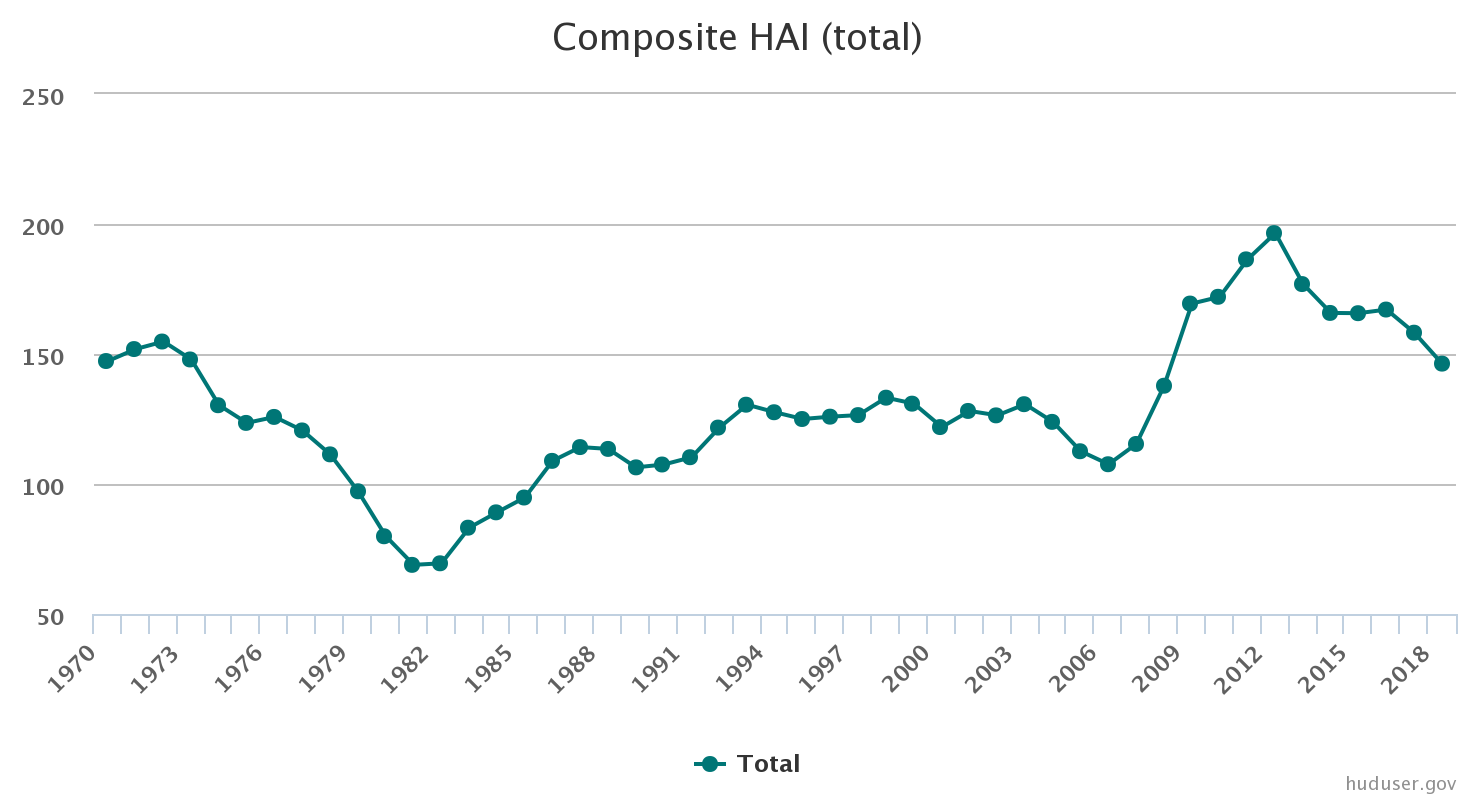

### Let's load the data.
The first step to any data science project is to import your data. Often, you'll work with data in Comma Separated Value (CSV) files and run into problems at the very start of your workflow. 

In [ ]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
df = pd.read_csv('../input/train.csv')

# How to get the number of elements:  
The ***shape*** attribute of pandas.DataFrame stores the number of rows and columns as a tuple (number of rows, number of columns).

In [ ]:
df.shape

# How to get the columns:  
To access the names of a Pandas dataframe, we can do the method columns().   
For example, if our dataframe is called df we just type print(*df. **columns***) to get all the columns of the pandas dataframe.

In [ ]:
df.columns

### Target variable

The **“target variable”** is the variable whose values are to be modeled and predicted by other variables. It is analogous to the dependent variable (i.e., the variable on the left of the equal sign) in linear regression. There must be one and only one target variable in a decision tree analysis. The target variable that we can use for this dataset is **['SalePrice']**.

In [ ]:
#statistics summary
df['SalePrice'].describe()

Which column in your tabular dataset will you predict?   
Let's choose: **['BedroomAbvGr']**

In [ ]:
df = df.dropna(subset=['BedroomAbvGr'])
df['Great'] = df['BedroomAbvGr'] >= 4


### Now, let's start cleaning the data

In [ ]:
cardinality = df.select_dtypes(exclude='number').nunique()

high_cardinality_feat = cardinality[cardinality > 20].index.tolist()
df = df.drop(columns = high_cardinality_feat)
df = df.fillna('Missing')

train = df[df['YrSold'] <= 2016]
val = df[df['YrSold'] == 2007]
test = df[df['YrSold'] <= 2008]

target = 'Great'
features = train.columns.drop([target, 'YrSold'])
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train, y_train)
print(f'Validation accuracy: {pipeline.score(X_val, y_val)}')

### Missing data

Important questions when thinking about missing data:

* How prevalent is the missing data?
* Is missing data random or does it have a pattern?

The answer to these questions is important for practical reasons because missing data can imply a reduction of the sample size. This can prevent us from proceeding with the analysis. Moreover, from a substantive perspective, we need to ensure that the missing data process is not biased and hidding an inconvenient truth.

# Let's review 'SalePrice'


In [ ]:
#scatter plot grlivarea/saleprice
var = 'GrLivArea'
data = pd.concat([df['SalePrice'], df[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

*In this model the  'SalePrice' and 'GrLivArea' are to closed to each others, with a <b>linear relationship.</b>*

*Let's review 'TotalBsmtSF'?*

In [ ]:
#scatter plot totalbsmtsf/saleprice
var = 'TotalBsmtSF'
data = pd.concat([df['SalePrice'], df[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

*Same as 'TotalBsmtSF'*

### Fitting the Linear Regression model  
Linear regression attempts to model the relationship between two variables by fitting a linear equation to observed data. One variable is considered to be an explanatory variable, and the other is considered to be a dependent variable.

In [ ]:
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

lr = make_pipeline(
    ce.TargetEncoder(),  
    LinearRegression()
)

lr.fit(X_train, y_train)
print('Linear Regression R^2', lr.score(X_val, y_val))

### Fit Gradient Boosting model   
Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically [decision trees](https://en.wikipedia.org/wiki/Decision_tree_learning).

In [ ]:
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

gb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

### Let's try 3D with Plotly

In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
features = ['LotArea', 'GarageCars']

interact = pdp_interact(
    model=gb,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

In [ ]:
pdp = interact.pdp.pivot_table(
    values='preds', 
    columns=features[0], 
    index=features[1]
)[::-1]

In [ ]:
import plotly.graph_objs as go

surface = go.Surface(
    x=pdp.columns, 
    y=pdp.index, 
    z=pdp.values
)


layout = go.Layout(
    scene=dict(
        xaxis=dict(title=features[0]), 
        yaxis=dict(title=features[1]), 
        zaxis=dict(title=target)
    )
)

fig = go.Figure(surface, layout)
fig.show()

### Fitting a model

In [ ]:
import category_encoders as ce
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

target = 'Great'
features = df.columns.drop(['Great', 'SaleCondition'])

X = df[features]
y = df[target]

# Use Ordinal Encoder, outside of a pipeline
encoder = ce.OrdinalEncoder()
X_encoded = encoder.fit_transform(X)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_encoded, y)

In [ ]:
feature = 'HouseStyle'
for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping']
        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

### Partial Dependence Plots with 2 features
Let's choose [*'HouseStyle', 'Fireplaces'*]

In [ ]:
features = ['HouseStyle', 'Fireplaces']

interaction = pdp_interact(
    model=model, 
    dataset=X_encoded, 
    model_features=X_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [ ]:
pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], # First feature on x axis
    index=features[1]    # Next feature on y axis
)[::-1]  # Reverse the index order so y axis is ascending

pdp = pdp.rename(columns=dict(zip(category_codes, category_names)))
plt.figure(figsize=(10,8))
sns.heatmap(pdp, annot=True, fmt='.3f', cmap='viridis')
plt.title('House Style with fireplace');

# Let's start the prediction.

In [ ]:
#shap
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


df = df.dropna(subset=['BedroomAbvGr'])
df['Great'] = df['BedroomAbvGr'] >= 4

cardinality = df.select_dtypes(exclude='number').nunique()

high_cardinality_feat = cardinality[cardinality > 20].index.tolist()
df = df.drop(columns = high_cardinality_feat)
df = df.fillna('Missing')

train = df[df['YrSold'] <= 2016]

test = df[df['YrSold'] <= 2008]

# Assign to X, y
target = 'SalePrice'
features = ['GarageCars', 'Fireplaces', 'FullBath']
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [ ]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_distributions = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42), 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=42
)

search.fit(X_train, y_train);

In [ ]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)
model = search.best_estimator_

In [ ]:
X_test.head(5)

In [ ]:
X_test.shape

### Get an individual observation to explain.  
For example, the 0th row from the test set.

In [ ]:
row = X_test.iloc[[0]]
row

### What was the actual sale's price?

In [ ]:
y_test.iloc[0]

### What does the model predict for this house sale?

In [ ]:
model.predict(row)

### Look at a Shapley Values Force Plot

In [ ]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)
shap_values

In [ ]:
explainer.expected_value

In [ ]:
y_train.mean()

In [ ]:
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)

### Define the predict function

In [ ]:
def predict(GarageCars, Fireplaces, FullBath):

    # Make dataframe from the inputs
    df = pd.DataFrame(
        data=[[GarageCars, Fireplaces, FullBath]], 
        columns=['GarageCars', 'Fireplaces', 'FullBath']
    )

    # Get the model's prediction
    pred = model.predict(df)[0]

    # Calculate shap values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(df)

    # Get series with shap values, feature names, & feature values
    feature_names = df.columns
    feature_values = df.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))

    # Print results
    result = f'${pred:,.0f} estimated sale price. \n\n'
    result += f'Starting from baseline of ${explainer.expected_value} \n'
    result += shaps.to_string()
    print(result)


    # Show shapley values force plot
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=df
    )

predict(3, 2, 2)

### For 2 garage cars  
You will see in the prediction below that the output value is lower.

In [ ]:
predict(2, 2, 2)

### Prediction for 1 fireplace only  
You will see in the prediction below that the output value is lower.

In [ ]:
predict(2, 1, 2)

### Let's add 1 full bath (3 full baths)
This shows that the output value is higher.

In [ ]:
predict(3, 2, 3)

# Clever Ways to Instantly Add Value to your Home

## 1. Add some smart technology   
Smart home technology was identified as a top trend in Zillow's 2019 Design Forecast. If you want to make your home more valuable, then it's time to start thinking smart. Investing in some smart home technology can increase your home's value quickly, without the expense of a huge renovation.


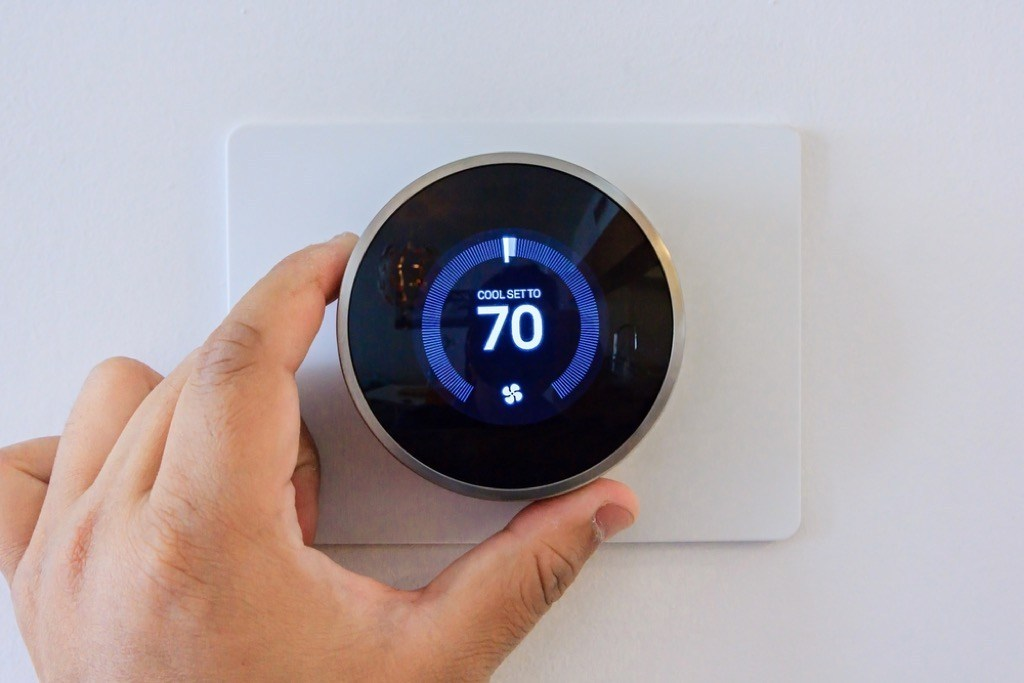

## 2. Remove your carpeting   
"Modern home buyers are turned off by carpeting," says Earl White, founder of House Heroes Realty and House Heroes, LLC. "Laying down a shiny new wood floor across easily pays for itself several times over." And if you're worried that authentic flooring is going to cost you an arm and a leg, there are always "good alternatives to traditional wood floors," says White. "Home renovators can buy engineered or laminate wood for a fraction of the cost of an expensive floor."

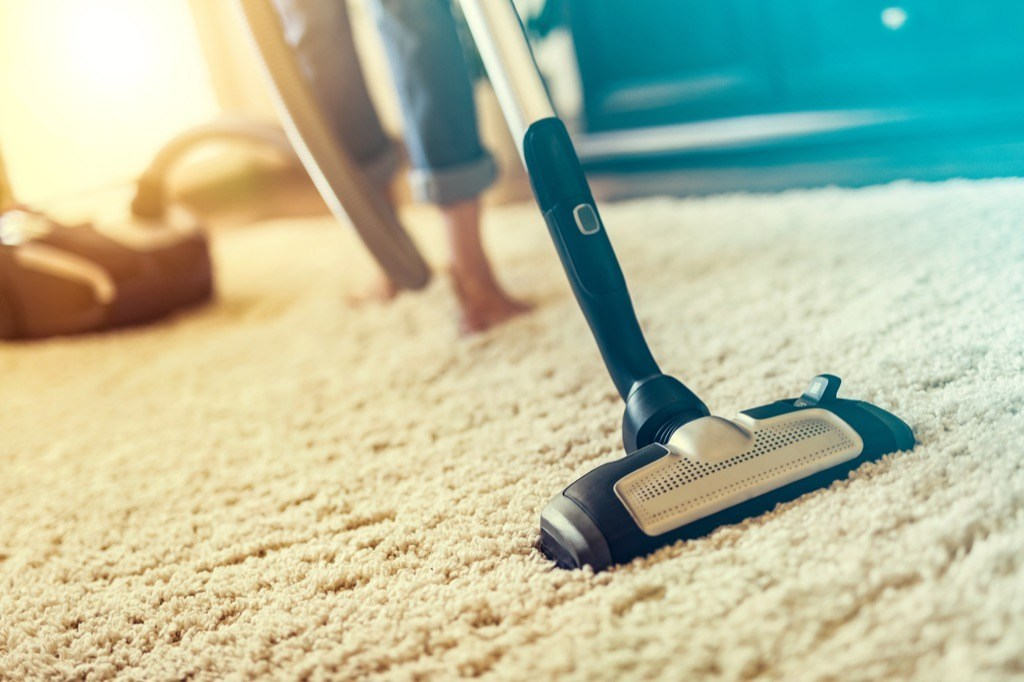

## 3. Replace your dated garage door    

Luckily, replacing it isn't a hugely pricey investment, and doing so can make your house much more attractive in the long run."By installing a new garage door, you can see up to a 92 percent return on your investment," says Palomino. "Garage doors boost curb appeal, provide safety and security, and even help on energy bills if insulated."

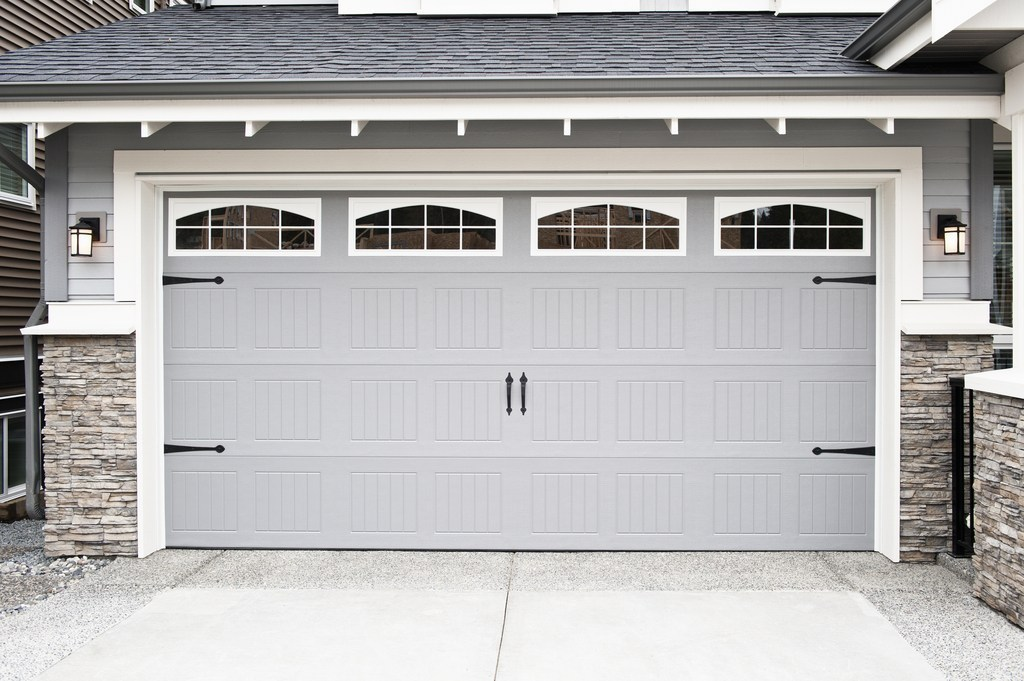

## 4. Redo your kitchen counters    
Those old laminate or tile counters are bringing down your home's appeal and its potential selling point. Luckily, installing granite or quartz counters is easy and it can quickly improve the look and value of your place. "Replacing counter tops can be completed for under $10,000 and will have a huge impact on value," says Franklin.

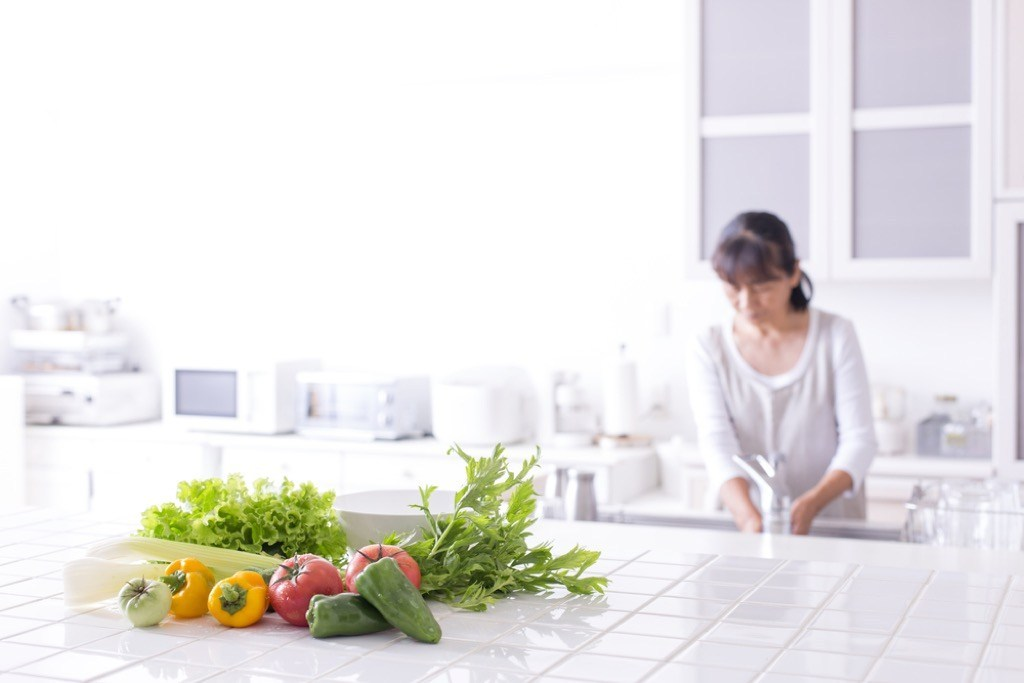

## 5. Install recessed lighting   
Want to make every room in your home look brighter, more beautiful, and more expensive? The answer is simple: recessed lighting."Living rooms should have four recessed lights, and hallways and kitchens should have a few too," suggests Brian Dougherty, managing partner at Robert Paul Properties in Boston. 

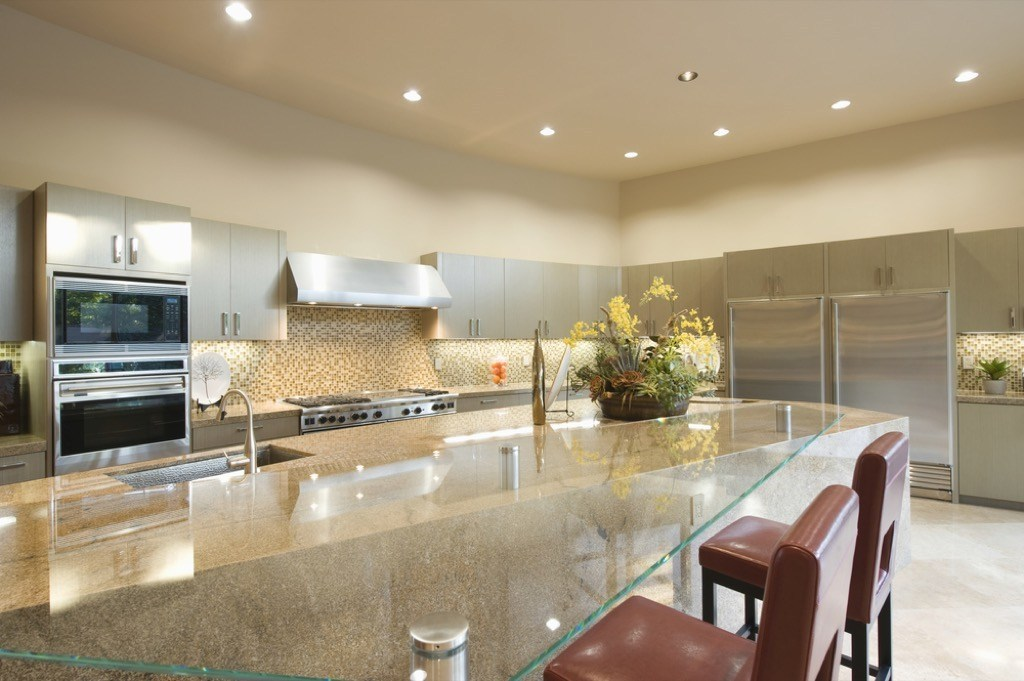

## 6. Go minimal   
As a general rule, ornate fabrics, patterns, and design styles generally won't yield a major ROI. When you're looking to improve your home's value, minimalism yields maximum money. Buyers today are very influenced by the home shows that they see on HGTV and that seems to dictate what many people say they are looking for: neutral colors, clean surfaces, and minimal window treatments.

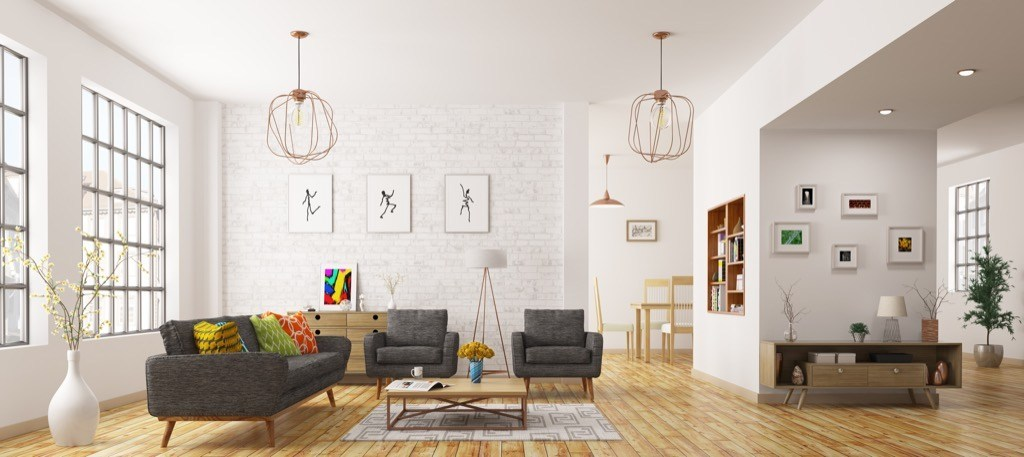

### These are the few tips in upgrading your home if your planning to sell your house.